In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Establish database connection
import psycopg2
dbname = 'beforeiagree_db'
username = 'peterostendorp'

#Create engine
con = psycopg2.connect(database = dbname, user = username)

In [3]:
sql = """
SELECT * FROM binary_segment_categories;
"""

segment_cats = pd.read_sql_query(sql,con)

In [4]:
sql = """
SELECT * FROM binary_policy_categories;
"""
policy_cats = pd.read_sql_query(sql,con)

In [5]:
import nltk

In [25]:
sql = """
SELECT "Policy UID", policy_text FROM sites;
"""
policies = pd.read_sql_query(sql,con)

In [7]:
from nltk.corpus import stopwords
import re
import string
def text_process_policy(doc):
    """
    1. remove punctuation
    2. remove stopwords
    3. remove HTML tags
    4. remove '|||' inserted into corpus documents only
    """
    lst = [word for word in doc.split() if re.search(r'\<.*\>',word) is None]
    lst = ' '.join(lst)
    lst = [char for char in lst if char not in string.punctuation]
    lst = ''.join(lst)    
    lst = [word for word in lst.split() if word.lower() not in stopwords.words('english')]
    lst = [word for word in lst if word.replace('|||','')]
    return ' '.join(lst)

## Frequency of terms across the whole corpus

In [26]:
policies = pd.merge(policies,policy_cats,on='Policy UID')

In [27]:
#Just grab a few policies to make a point
policies = policies.iloc[:10]

,Policy UID,policy_text,other,policy_change,first_party_collection_use,third_party_sharing_collection,do_not_track,user_choice_control,international_specific_audiences,data_security,data_retention,user_access_edit_deletion
0,20,<strong> Privacy Policy </strong> <br> <br> <s...,1,1,1,1,1,1,1,1,1,1
1,21,"IMDb Privacy Notice <br> <br>|||Last Updated, ...",1,1,1,1,0,1,1,1,0,1
2,26,<strong> Privacy Policy </strong> <br> <br> La...,1,1,1,1,0,1,1,1,0,1
3,32,Vox Media Privacy Policy <br> <br>|||<strong> ...,1,1,1,1,0,1,1,1,1,0
4,32,Vox Media Privacy Policy <br> <br>|||<strong> ...,1,1,1,1,0,1,1,1,1,0


In [30]:
policies['policy_text'].apply(text_process_policy)

0    Privacy Policy Effective January 1 2015 Atlant...
1    IMDb Privacy Notice Updated December 5 2014 se...
2    Privacy Policy Last Updated June 10 2015 Priva...
3    Vox Media Privacy Policy Updated May 2014 Vox ...
4    Vox Media Privacy Policy Updated May 2014 Vox ...
5    Vox Media Privacy Policy Updated May 2014 Vox ...
6    Vox Media Privacy Policy Updated May 2014 Vox ...
7    Vox Media Privacy Policy Updated May 2014 Vox ...
8    Vox Media Privacy Policy Updated May 2014 Vox ...
9    Vox Media Privacy Policy Updated May 2014 Vox ...
Name: policy_text, dtype: object

In [90]:
policies['policy_text'] = policies['policy_text'].apply(text_process_policy)

In [91]:
words = ' '.join(list(policies['policy_text'])).split()

In [10]:
from nltk.probability import FreqDist

In [92]:
f = FreqDist(words)

In [93]:
df = pd.DataFrame(f.most_common(100),columns=['Word','Frequency']).set_index('Word')

In [94]:
df.head()

,Frequency
Word,
information,464
may,336
Services,280
use,261
us,249


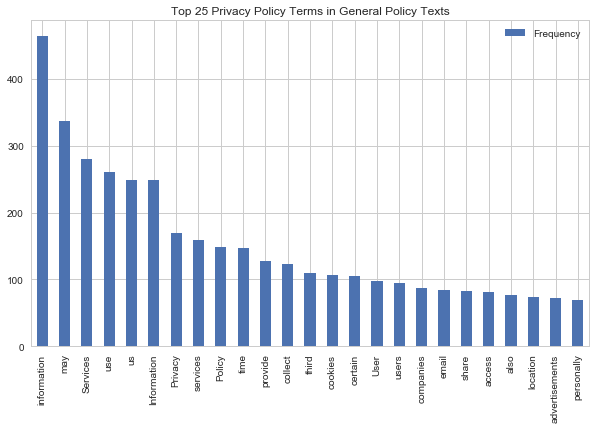

In [96]:
#Word frequency stuff
sns.set_style('whitegrid')
df.iloc[:25].plot.bar(figsize=(10,6))
plt.title('Top 25 Privacy Policy Terms in General Policy Texts')
plt.xlabel('')
plt.savefig('../figures/top25terms.png')

## Frequency of terms just across "Data Security" annotations

In [50]:
#Get segments annotated as 'Data security'
sql = """
SELECT * FROM segments;
"""
segments = pd.read_sql_query(sql,con)

sql = """
SELECT * FROM annotations;
"""
annotations = pd.read_sql_query(sql,con)

In [51]:
segments.head()

,Policy UID,segment_id,segments
0,20,0,<strong> Privacy Policy </strong> <br> <br> <s...
1,20,1,This privacy policy does not apply to Sites ma...
2,20,2,"By visiting our Sites, you are accepting the p..."
3,20,3,<strong> What Information Is Collected? </stro...
4,20,4,<strong> Personally Identifiable Information <...


In [52]:
annotations.head()

,Policy UID,annotation_id,batch_id,annotator_id,segment_id,category_name,attributes_value_pairs,date,policy_url
0,1017,20137,test_category_labeling_highlight_fordham_aaaaa,121,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",NaT,http://www.sci-news.com/privacy-policy.html
1,1017,20324,test_category_labeling_highlight_fordham_aaaaa,121,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",NaT,http://www.sci-news.com/privacy-policy.html
2,1017,20325,test_category_labeling_highlight_fordham_aaaaa,121,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",NaT,http://www.sci-news.com/privacy-policy.html
3,1017,20326,test_category_labeling_highlight_fordham_aaaaa,121,2,Data Retention,"{""Personal Information Type"": {""selectedText"":...",NaT,http://www.sci-news.com/privacy-policy.html
4,1017,20327,test_category_labeling_highlight_fordham_aaaaa,121,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele...",NaT,http://www.sci-news.com/privacy-policy.html


In [53]:
segments = pd.merge(annotations,segments,on=['Policy UID','segment_id'],how='outer')

In [54]:
segments = pd.merge(policies,segments,on='Policy UID',how='inner')

In [55]:
segments = segments.drop(['other', 'policy_change',
       'first_party_collection_use', 'third_party_sharing_collection',
       'do_not_track', 'user_choice_control',
       'international_specific_audiences', 'data_security', 'data_retention',
       'user_access_edit_deletion', 'batch_id', 'attributes_value_pairs'],
             axis=1)

In [57]:
segments = segments[segments['category_name']=='Data Security']

In [58]:
#Apply same workflow as above to break down to list of words
#segments.iloc[0]['segments'].apply(text_process_policy)
segments['segments'] = segments['segments'].apply(text_process_policy)
words = ' '.join(list(segments['segments'])).split()

In [83]:
segments.head()

,Policy UID,annotation_id,batch_id,annotator_id,segment_id,category_name,attributes_value_pairs,date,policy_url,segments
0,1017,20137,test_category_labeling_highlight_fordham_aaaaa,121,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",NaT,http://www.sci-news.com/privacy-policy.html,Privacy Policy <br> <br> Sci-News.com is commi...
1,1017,20589,test_category_labeling_highlight_fordham_ccccc,117,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",NaT,http://www.sci-news.com/privacy-policy.html,Privacy Policy <br> <br> Sci-News.com is commi...
2,1017,20233,test_category_labeling_highlight_fordham_ddddd,118,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",NaT,http://www.sci-news.com/privacy-policy.html,Privacy Policy <br> <br> Sci-News.com is commi...
3,1017,20234,test_category_labeling_highlight_fordham_ddddd,118,0,Policy Change,"{""Change Type"": {""selectedText"": ""Please note ...",NaT,http://www.sci-news.com/privacy-policy.html,Privacy Policy <br> <br> Sci-News.com is commi...
4,1017,20324,test_category_labeling_highlight_fordham_aaaaa,121,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",NaT,http://www.sci-news.com/privacy-policy.html,Information that Sci-News.com May Collect Onli...


In [59]:
f2 = FreqDist(words)

In [60]:
df2 = pd.DataFrame(f2.most_common(100),columns=['Word','Frequency']).set_index('Word')

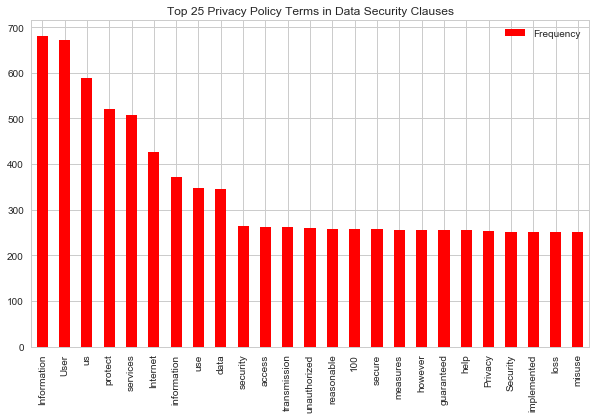

In [61]:
#Word frequency stuff
sns.set_style('whitegrid')
df2.iloc[:25].plot.bar(figsize=(10,6),color='red')
plt.title('Top 25 Privacy Policy Terms in Data Security Clauses')
plt.xlabel('')
plt.savefig('../figures/top25terms_data_security.png')